# Simulating Model‑Collapse on US Mortgage‑Application Data 

**Data Set:**
* **Source:** 2023 Home‑Mortgage‑Disclosure Act (HMDA) public release, Federal Financial Institutions Examination Council (FFIEC).
* **Sample:** 100 000 randomly‑drawn loan applications.
* **Target label:** `Approved (1 = Yes)` (1 = approved, 0 = denied).
* **Features:** ≈ 27 columns covering geography, income, loan details, race, ethnicity, sex, etc.  Numerical + categorical.

**Simulations**

* **Objective:** Much like with the MCMC name generator simulation, the goal of this experiemnt is to study model collapse—performance and fairness drift when a model is recursively retrained on its own synthetic labels and features while all real/ original input features remain available.
* **Loop:**
    1. Clean & split (once) [Remove ultra‑rare race labels and tiny (race, sex) strata. Train/test split]
    2. Pre‑process (every generation) [Numeric features get standardized, Categorical features get encoded.
    3. Generation 0: [Train logistic regression on real labels, Save predicted probability column Approval_Score_1 to train & test sets]
    4. Generation 1 to `n`: 
        1. Add synthetic labels mix: randomly replace a fraction (25 % per generation) of training labels with previous‑generation hard predictions.
        2. Re‑preprocess (now including all accumulated Approval_Score_k columns).
        3. Retrain logistic regression 
        4. Save new probability column Approval_Score_{n} . 

* **The idea is that every generation will add a column with synthetic data to the dataset, and a number of the previous model's predictions will be integrated as `y_true`.**

**Hyperparameters:**
* w: The proportion of labels in the following generation's data that will be synthetic (i.e - adopted by the previous generation's prediction)
* num_gens: Number of generations the loop runs for

**Metrics** 
* **AUC:** Ranking quality across all thresholds. The higher the value (max = 1), the better the model ranks positives above negatives across all thresholds.
* **KL divergence vs. Gen 0:** Distributional drift of predicted probabilities.THe higher the KL divergence the more different the models are from Gen 0. 
* **Group FPR / FNR by race & sex:** Error‑type differences by race/sex gorup.
* **Disparate‑Impact (DI):** Selection‑rate ratio vs. majority race/sex. Growing DI = More unfair



# Simulating Model‑Collapse on US Mortgage‑Application Data (2023 Sample)

## 1. Dataset

* **Source:** 2023 Home‑Mortgage‑Disclosure Act (HMDA) public release, Federal Financial Institutions Examination Council (FFIEC).
* **Sample:** 100 000 randomly‑drawn loan applications.
* **Target label:** `Approved (1 = Yes)` (1 = approved, 0 = denied).
* **Features:** ≈ 27 columns covering geography, income, loan details, race, ethnicity, sex, etc.  Numerical + categorical.

## 2. Goal

Study **model collapse**—performance and fairness drift when a model is recursively retrained on its **own synthetic labels** while *all real input features* remain available.

## 3. Generation‑by‑Generation Pipeline

| Stage                             | Action                                                                                                                                                                                                                                                                                                                                                     |
| --------------------------------- | ---------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------- |
| **A. Clean & Split (once)**       | • Remove ultra‑rare race labels and tiny (race, sex) strata.• Drop the identifier `lei`.• Train/test split (80 / 20) stratified by race × sex.                                                                                                                                                                                                             |
| **B. Pre‑processing (every gen)** | • **Numeric** features ➜ z‑score with `StandardScaler`.• **Categorical** features ➜ one‑hot (drop first).                                                                                                                                                                                                                                                  |
| **C. Baseline model (G⁰)**        | Train logistic‑regression (`lbfgs`, max\_iter = 5000) on real labels.  Save predicted probability `Approval_Score_1` to both sets.                                                                                                                                                                                                                         |
| **D. Recursive loop (G¹…Gᴺ)**     | 1. **Label blending:** randomly replace `synth_w = min(1, base_w·g)` fraction (25 % per gen) of *training* labels with previous‑gen hard predictions.2. Re‑preprocess (now including all accumulated `Approval_Score_k` columns).3. Retrain logistic regression (max\_iter = 2000).4. Save new probability `Approval_Score_{g+1}` (except after last gen). |

### Hyper‑parameters

* `base_w = 0.25`   → synthetic share 25 %, 50 %, 75 %, …
* `num_gens = 10`    → 11 total generations (0…10).
* 50‑bin score histogram saved from Gen 0 for KL reference.

## 4. Metrics Collected Each Generation

| Metric                            | Purpose                                          |
| --------------------------------- | ------------------------------------------------ |
| **Accuracy** (0.5 cut)            | threshold‑specific performance snapshot.         |
| **AUC**                           | ranking quality across all thresholds.           |
| **KL Divergence to Gen 0**        | distributional drift of predicted probabilities. |
| **Group FPR / FNR** by race & sex | error‑type disparities.                          |
| **Disparate‑Impact (DI)**         | selection‑rate ratio vs. majority race/sex.      |
|                                   |                                                  |

## 5. Interpretation Aids

* **Flat accuracy + rising KL/AUC drop** ⇒ early collapse: score calibration/ordering erodes before decision boundary moves.
* **Growing DI / EO gaps** ⇒ fairness deterioration as synthetic‑label noise accumulates.

## 6. Outputs

* `metrics_df` (table of all metrics per generation).
* Publication‑style PNG plots: AUC, KL, FPR/FNR, DI (race & sex), EO gaps.

Use this document as the method section for the project report or as in‑canvas notes when iterating further.


In [20]:
import pandas as pd
df = pd.read_excel("C:/Users/milos/OneDrive/Data_Ethics_repo/DATA_259_Project/Data/Working Sample/sample.xlsx")

## Data Preparation and Preprocessing


In [22]:
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score

# -----------------------------------------------------------
# 0.  Basic clean-up: drop lei, rare race label, tiny strata
# -----------------------------------------------------------
df = (
    df                     # start from original df
    .drop(columns=['lei'], errors='ignore')
    .loc[df['derived_race'] != 'Free Form Text Only']  # drop ultra-rare label
    .copy()
)

# drop any (race,sex) strata with <100 rows (change threshold if needed)
stratum_counts = df.groupby(['derived_race', 'derived_sex']).size()
rare_strata = stratum_counts[stratum_counts < 100].index          # tuples
if len(rare_strata):
    mask = df.set_index(['derived_race', 'derived_sex']).index.isin(rare_strata)
    df = df.loc[~mask]
df = df.reset_index(drop=True)

print("Minimum stratum size after filtering:",
      df.groupby(['derived_race', 'derived_sex']).size().min())

# -----------------------------------------------------------
# 1.  Split features / target
# -----------------------------------------------------------
target_col = 'Approved (1 = Yes) (Base)'
X = df.drop(columns=[target_col])
y = df[target_col]

X_train_orig, X_test_orig, y_train, y_test = train_test_split(
    X, y, test_size=0.20, random_state=42,
    stratify=df[['derived_race', 'derived_sex']]
)

# -----------------------------------------------------------
# 2.  Identify numeric vs. categorical correctly
# -----------------------------------------------------------
#   • numeric: anything pandas already thinks is number *plus*
#     object columns that actually look numeric after coercion
numeric_cols = (
    list(X_train_orig.select_dtypes(include=[np.number]).columns) +
    [
        col for col in X_train_orig.select_dtypes(include='object').columns
        if pd.to_numeric(X_train_orig[col], errors='coerce').notna().any()
    ]
)
numeric_cols = list(dict.fromkeys(numeric_cols))   # deduplicate

categorical_cols = [c for c in X_train_orig.columns
                    if c not in numeric_cols]      # everything else is categorical

# -----------------------------------------------------------
# 3.  Coerce numeric-looking strings → floats
# -----------------------------------------------------------
for col in numeric_cols:
    # This leaves genuine strings untouched (they stay NaN after coercion)
    X_train_orig[col] = pd.to_numeric(X_train_orig[col], errors='coerce')
    X_test_orig[col]  = pd.to_numeric(X_test_orig[col], errors='coerce')

# Optionally fill NaNs in numeric columns with training-set medians
medians = X_train_orig[numeric_cols].median()
X_train_orig[numeric_cols] = X_train_orig[numeric_cols].fillna(medians)
X_test_orig[numeric_cols]  = X_test_orig[numeric_cols].fillna(medians)

# -----------------------------------------------------------
# 4.  Scale numerics, one-hot categoricals
# -----------------------------------------------------------
scaler = StandardScaler()
X_train_num = pd.DataFrame(
    scaler.fit_transform(X_train_orig[numeric_cols]),
    columns=numeric_cols, index=X_train_orig.index
)
X_test_num = pd.DataFrame(
    scaler.transform(X_test_orig[numeric_cols]),
    columns=numeric_cols, index=X_test_orig.index
)

X_train_cat = pd.get_dummies(X_train_orig[categorical_cols], drop_first=True)
X_test_cat  = pd.get_dummies(X_test_orig[categorical_cols], drop_first=True)
X_test_cat  = X_test_cat.reindex(columns=X_train_cat.columns, fill_value=0)

X_train_proc = pd.concat([X_train_num, X_train_cat], axis=1)
X_test_proc  = pd.concat([X_test_num,  X_test_cat],  axis=1)

# -----------------------------------------------------------
# 5.  Reference groups for disparate-impact
# -----------------------------------------------------------
ref_race = X_train_orig['derived_race'].value_counts().idxmax()
ref_sex  = X_train_orig['derived_sex'].value_counts().idxmax()
print(f"Reference race: {ref_race}, reference sex: {ref_sex}")

# Now StandardScaler sees only floats — no more “could not convert string to float” errors.


Minimum stratum size after filtering: 154
Reference race: White, reference sex: Joint


## Model Loop with 1% Increment


In [3]:
import numpy as np, pandas as pd, matplotlib.pyplot as plt
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import accuracy_score, roc_auc_score
from sklearn.linear_model import LogisticRegression
from scipy.stats import entropy 

# ------------------------------------------------ helpers
def build_proc(tr_raw, te_raw, num_cols, cat_cols):
    sc = StandardScaler()
    tr_num = pd.DataFrame(sc.fit_transform(tr_raw[num_cols]), columns=num_cols, index=tr_raw.index)
    te_num = pd.DataFrame(sc.transform(te_raw[num_cols]),  columns=num_cols, index=te_raw.index)
    if cat_cols:
        tr_cat = pd.get_dummies(tr_raw[cat_cols], drop_first=True)
        te_cat = pd.get_dummies(te_raw[cat_cols], drop_first=True).reindex(columns=tr_cat.columns, fill_value=0)
        tr_proc, te_proc = pd.concat([tr_num, tr_cat], axis=1), pd.concat([te_num, te_cat], axis=1)
    else:   # no categoricals (after Gen 0)
        tr_proc, te_proc = tr_num, te_num
    return tr_proc, te_proc

def rates(y_true, y_pred):
    fp = ((y_pred==1)&(y_true==0)).sum()
    fn = ((y_pred==0)&(y_true==1)).sum()
    tn = ((y_pred==0)&(y_true==0)).sum()
    tp = ((y_pred==1)&(y_true==1)).sum()
    fpr = fp/(fp+tn) if (fp+tn) else np.nan
    fnr = fn/(fn+tp) if (fn+tp) else np.nan
    return fpr, fnr

# ------------------------------------------------ initial copies
X_tr, X_te = X_train_orig.copy(), X_test_orig.copy()
y_tr_true = y_train.copy()

metrics_rows = []

# attributes for group metrics
race_groups = X_te['derived_race'].unique()
sex_groups  = X_te['derived_sex'].unique()
ref_race = X_tr['derived_race'].value_counts().idxmax()
ref_sex  = X_tr['derived_sex'].value_counts().idxmax()

# ------------------------------------------------ Generation 0
proc_tr, proc_te = build_proc(X_tr, X_te, numeric_cols, categorical_cols)
clf = LogisticRegression(solver='lbfgs', max_iter=5000, n_jobs=-1, random_state=42)
clf.fit(proc_tr, y_tr_true)
tr_prob = clf.predict_proba(proc_tr)[:,1]
te_prob = clf.predict_proba(proc_te)[:,1]

X_tr['Approval_Score_1'] = tr_prob
X_te['Approval_Score_1'] = te_prob
numeric_cols.append('Approval_Score_1')
prev_bin = (tr_prob>=0.5).astype(int)       # for blending next gen

def log_metrics(gen, y_true, prob, X_test, ref_hist=None, bin_edges=None):
    y_bin = (prob >= 0.5).astype(int)
    row = {
        'generation': gen,
        'accuracy': accuracy_score(y_true, y_bin),
        'auc': roc_auc_score(y_true, prob)
    }

    # ---------- KL divergence (optional for gen>0) ------------------------
    if ref_hist is not None and bin_edges is not None:
        cur_hist, _ = np.histogram(prob, bins=bin_edges, density=True)
        # add ε to avoid log(0)
        row['KL_to_baseline'] = entropy(cur_hist + 1e-12, ref_hist + 1e-12)
    else:
        row['KL_to_baseline'] = 0.0      # Gen-0 baseline

    # ---------- group fairness metrics (unchanged) ------------------------
    for r in race_groups:
        mask = X_test['derived_race'] == r
        fpr, fnr = rates(y_true[mask], y_bin[mask])
        sel      = (y_bin[mask] == 1).mean()
        sel_ref  = (y_bin[X_test['derived_race'] == ref_race] == 1).mean()
        row[f'FPR_race_{r}'] = fpr
        row[f'FNR_race_{r}'] = fnr
        row[f'DI_race_{r}']  = sel / sel_ref if sel_ref else np.nan

    for s in sex_groups:
        mask = X_test['derived_sex'] == s
        fpr, fnr = rates(y_true[mask], y_bin[mask])
        sel      = (y_bin[mask] == 1).mean()
        sel_ref  = (y_bin[X_test['derived_sex'] == ref_sex] == 1).mean()
        row[f'FPR_sex_{s}'] = fpr
        row[f'FNR_sex_{s}'] = fnr
        row[f'DI_sex_{s}']  = sel / sel_ref if sel_ref else np.nan
    return row

metrics_rows.append(
    log_metrics(0, y_test, te_prob, X_te, ref_hist=None, bin_edges=None)
)

# reference histogram for KL
baseline_hist, bin_edges = np.histogram(te_prob, bins=50, range=(0, 1), density=True)



# ------------------- Progressive loop (no feature drop) -------------------
base_w, num_gens = 0.01, 100          # 25 % more synthetic each gen
for g in range(1, num_gens + 1):
    print(f"Gen {g}…  (synthetic weight {min(1, base_w*g):.2f})")

    # 1.  Blend labels ------------------------------------------------------
    synth_w = min(1.0, base_w * g)
    y_blend = y_tr_true.copy()
    repl_idx = np.random.choice(len(y_blend), int(synth_w * len(y_blend)), replace=False)
    y_blend.iloc[repl_idx] = prev_bin[repl_idx]

    # 2.  Re-build processed matrices with *all* original features + scores
    proc_tr, proc_te = build_proc(X_tr, X_te, numeric_cols, categorical_cols)

    # 3.  Retrain logistic regression --------------------------------------
    clf = LogisticRegression(solver="lbfgs", max_iter=2000, n_jobs=-1, random_state=42)
    clf.fit(proc_tr, y_blend)

    # 4.  Predictions and new synthetic score ------------------------------
    tr_prob = clf.predict_proba(proc_tr)[:, 1]
    te_prob = clf.predict_proba(proc_te)[:, 1]
    prev_bin = (tr_prob >= 0.5).astype(int)

    if g < num_gens:                    # add feature for next round
        sc_name = f"Approval_Score_{g+1}"
        X_tr[sc_name] = tr_prob
        X_te[sc_name] = te_prob
        numeric_cols.append(sc_name)    # keep expanding numeric list

    # 5.  Log metrics (unchanged) ------------------------------------------
    metrics_rows.append(
        log_metrics(g, y_test, te_prob, X_te,
                    ref_hist=baseline_hist, bin_edges=bin_edges)
    )


# assemble results
metrics_df = pd.DataFrame(metrics_rows)



Gen 1…  (synthetic weight 0.01)
Gen 2…  (synthetic weight 0.02)
Gen 3…  (synthetic weight 0.03)
Gen 4…  (synthetic weight 0.04)
Gen 5…  (synthetic weight 0.05)
Gen 6…  (synthetic weight 0.06)
Gen 7…  (synthetic weight 0.07)
Gen 8…  (synthetic weight 0.08)
Gen 9…  (synthetic weight 0.09)
Gen 10…  (synthetic weight 0.10)
Gen 11…  (synthetic weight 0.11)
Gen 12…  (synthetic weight 0.12)
Gen 13…  (synthetic weight 0.13)
Gen 14…  (synthetic weight 0.14)
Gen 15…  (synthetic weight 0.15)
Gen 16…  (synthetic weight 0.16)
Gen 17…  (synthetic weight 0.17)
Gen 18…  (synthetic weight 0.18)
Gen 19…  (synthetic weight 0.19)
Gen 20…  (synthetic weight 0.20)
Gen 21…  (synthetic weight 0.21)
Gen 22…  (synthetic weight 0.22)
Gen 23…  (synthetic weight 0.23)
Gen 24…  (synthetic weight 0.24)
Gen 25…  (synthetic weight 0.25)
Gen 26…  (synthetic weight 0.26)
Gen 27…  (synthetic weight 0.27)
Gen 28…  (synthetic weight 0.28)
Gen 29…  (synthetic weight 0.29)
Gen 30…  (synthetic weight 0.30)
Gen 31…  (synthetic

C:\Users\milos\AppData\Local\Temp\ipykernel_42616\914718575.py:123: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  X_tr[sc_name] = tr_prob
C:\Users\milos\AppData\Local\Temp\ipykernel_42616\914718575.py:124: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  X_te[sc_name] = te_prob


Gen 98…  (synthetic weight 0.98)


C:\Users\milos\AppData\Local\Temp\ipykernel_42616\914718575.py:123: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  X_tr[sc_name] = tr_prob
C:\Users\milos\AppData\Local\Temp\ipykernel_42616\914718575.py:124: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  X_te[sc_name] = te_prob


Gen 99…  (synthetic weight 0.99)


C:\Users\milos\AppData\Local\Temp\ipykernel_42616\914718575.py:123: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  X_tr[sc_name] = tr_prob
C:\Users\milos\AppData\Local\Temp\ipykernel_42616\914718575.py:124: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  X_te[sc_name] = te_prob


Gen 100…  (synthetic weight 1.00)


## Vizualisations

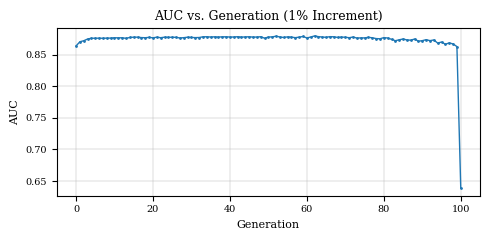

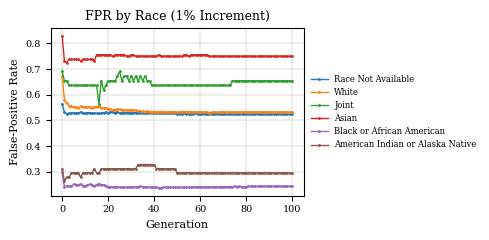

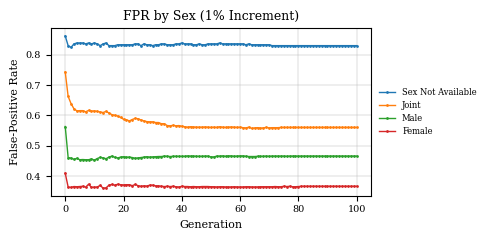

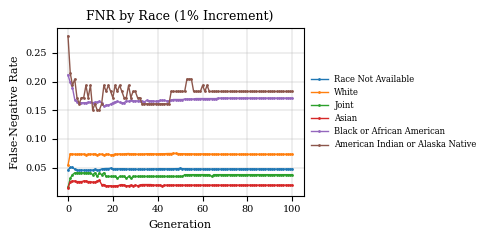

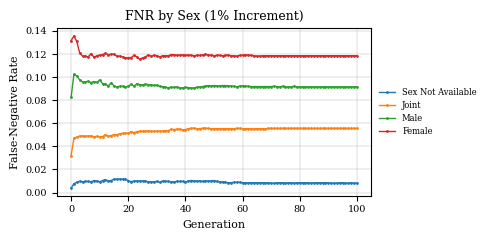

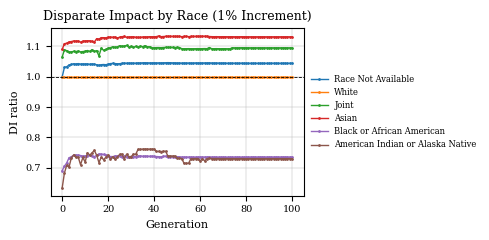

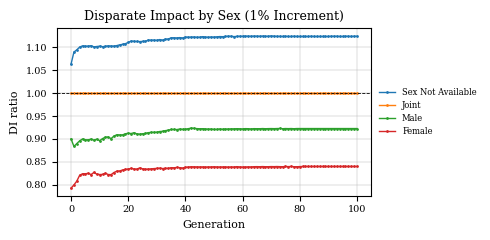

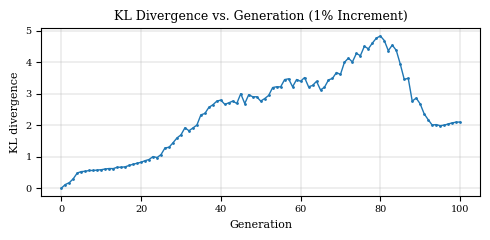

In [6]:
# --------------------------------------------------------
#  Publication-style figures with smaller markers & legends outside
# --------------------------------------------------------
pub_rc = {
    "figure.figsize": (5, 2.5),
    "font.family":    "serif",
    "axes.labelsize": 8,
    "axes.titlesize": 9,
    "xtick.labelsize":7,
    "ytick.labelsize":7,
    "lines.linewidth":1,
    "savefig.dpi":    300,
}

with plt.rc_context(pub_rc):

    # --- AUC (unchanged) ----------------------------------
    fig = plt.figure()
    plt.plot(metrics_df.generation, metrics_df.auc,
             marker="o", markersize=1)
    plt.xlabel("Generation"); plt.ylabel("AUC")
    plt.title("AUC vs. Generation (1% Increment)")
    plt.grid(True, linewidth=.3)
    plt.tight_layout(); plt.savefig("perf_vs_gen.png"); plt.show()

    # --- FPR by race --------------------------------------
    fig = plt.figure()
    for r in race_groups:
        plt.plot(metrics_df.generation,
                 metrics_df[f"FPR_race_{r}"],
                 marker="o", markersize=1,
                 label=r)
    plt.xlabel("Generation"); plt.ylabel("False-Positive Rate")
    plt.title("FPR by Race (1% Increment)")
    plt.grid(True, linewidth=.3)
    plt.legend(loc="center left", bbox_to_anchor=(1,0.5), fontsize=6, frameon=False)
    plt.tight_layout(); plt.savefig("fpr_race.png"); plt.show()

    # --- FPR by sex ---------------------------------------
    fig = plt.figure()
    for s in sex_groups:
        plt.plot(metrics_df.generation,
                 metrics_df[f"FPR_sex_{s}"],
                 marker="o", markersize=1,
                 label=s)
    plt.xlabel("Generation"); plt.ylabel("False-Positive Rate")
    plt.title("FPR by Sex (1% Increment)")
    plt.grid(True, linewidth=.3)
    plt.legend(loc="center left", bbox_to_anchor=(1,0.5), fontsize=6, frameon=False)
    plt.tight_layout(); plt.savefig("fpr_sex.png"); plt.show()

    # --- FNR by race --------------------------------------
    fig = plt.figure()
    for r in race_groups:
        plt.plot(metrics_df.generation,
                 metrics_df[f"FNR_race_{r}"],
                 marker="o", markersize=1,
                 label=r)
    plt.xlabel("Generation"); plt.ylabel("False-Negative Rate")
    plt.title("FNR by Race (1% Increment)")
    plt.grid(True, linewidth=.3)
    plt.legend(loc="center left", bbox_to_anchor=(1,0.5), fontsize=6, frameon=False)
    plt.tight_layout(); plt.savefig("fnr_race.png"); plt.show()

    # --- FNR by sex ------------------------------------------
    fig = plt.figure()
    for s in sex_groups:
        plt.plot(metrics_df.generation,
                 metrics_df[f"FNR_sex_{s}"],
                 marker="o", markersize=1,
                 label=s)
    plt.xlabel("Generation"); plt.ylabel("False-Negative Rate")
    plt.title("FNR by Sex (1% Increment)")
    plt.grid(True, linewidth=.3)
    plt.legend(loc="center left", bbox_to_anchor=(1,0.5), fontsize=6, frameon=False)
    plt.tight_layout(); plt.savefig("fnr_race.png"); plt.show()

    # --- DI by race ---------------------------------------
    fig = plt.figure()
    for r in race_groups:
        plt.plot(metrics_df.generation,
                 metrics_df[f"DI_race_{r}"],
                 marker="o", markersize=1,
                 label=r)
    plt.xlabel("Generation"); plt.ylabel("DI ratio")
    plt.title("Disparate Impact by Race (1% Increment)")
    plt.axhline(1, ls="--", lw=.6, c="k")
    plt.grid(True, linewidth=.3)
    plt.legend(loc="center left", bbox_to_anchor=(1,0.5), fontsize=6, frameon=False)
    plt.tight_layout(); plt.savefig("di_race.png"); plt.show()
 
    # --- DI by sex ----------------------------------------
    fig = plt.figure()
    for s in sex_groups:
        plt.plot(metrics_df.generation,
                 metrics_df[f"DI_sex_{s}"],
                 marker="o", markersize=1,
                 label=s)
    plt.xlabel("Generation"); plt.ylabel("DI ratio")
    plt.title("Disparate Impact by Sex (1% Increment)")
    plt.axhline(1, ls="--", lw=.6, c="k")
    plt.grid(True, linewidth=.3)
    plt.legend(loc="center left", bbox_to_anchor=(1,0.5), fontsize=6, frameon=False)
    plt.tight_layout(); plt.savefig("di_sex.png"); plt.show()

    pub_rc = {
    "figure.figsize": (3.5, 2.5),
    "font.family": "serif",
    "axes.labelsize": 8,
    "axes.titlesize": 9,
    "xtick.labelsize": 7,
    "ytick.labelsize": 7,
    "lines.linewidth": 1,
    "savefig.dpi": 300,
}

    fig = plt.figure()
    plt.plot(metrics_df.generation,
             metrics_df.KL_to_baseline,
             marker="o", markersize=1)
    plt.xlabel("Generation")
    plt.ylabel("KL divergence")
    plt.title("KL Divergence vs. Generation (1% Increment)")
    plt.grid(True, linewidth=.3)
    plt.tight_layout()
    plt.savefig("kl_vs_gen.png")
    plt.show()



## Model Loop with 5% Increment


In [17]:
# ------------------------------------------------ initial copies
X_tr, X_te = X_train_orig.copy(), X_test_orig.copy()
y_tr_true = y_train.copy()

metrics_rows = []

# attributes for group metrics
race_groups = X_te['derived_race'].unique()
sex_groups  = X_te['derived_sex'].unique()
ref_race = X_tr['derived_race'].value_counts().idxmax()
ref_sex  = X_tr['derived_sex'].value_counts().idxmax()

# ------------------------------------------------ Generation 0
proc_tr, proc_te = build_proc(X_tr, X_te, numeric_cols, categorical_cols)
clf = LogisticRegression(solver='lbfgs', max_iter=5000, n_jobs=-1, random_state=42)
clf.fit(proc_tr, y_tr_true)
tr_prob = clf.predict_proba(proc_tr)[:,1]
te_prob = clf.predict_proba(proc_te)[:,1]

X_tr['Approval_Score_1'] = tr_prob
X_te['Approval_Score_1'] = te_prob
numeric_cols.append('Approval_Score_1')
prev_bin = (tr_prob>=0.5).astype(int)       # for blending next gen


metrics_rows.append(
    log_metrics(0, y_test, te_prob, X_te, ref_hist=None, bin_edges=None)
)

# reference histogram for KL
baseline_hist, bin_edges = np.histogram(te_prob, bins=50, range=(0, 1), density=True)



# ------------------- Progressive loop (no feature drop) -------------------
base_w, num_gens = 0.05, 20          # 5 % more synthetic each gen
for g in range(1, num_gens + 1):
    print(f"Gen {g}…  (synthetic weight {min(1, base_w*g):.2f})")

    # 1.  Blend labels ------------------------------------------------------
    synth_w = min(1.0, base_w * g)
    y_blend = y_tr_true.copy()
    repl_idx = np.random.choice(len(y_blend), int(synth_w * len(y_blend)), replace=False)
    y_blend.iloc[repl_idx] = prev_bin[repl_idx]

    # 2.  Re-build processed matrices with *all* original features + scores
    proc_tr, proc_te = build_proc(X_tr, X_te, numeric_cols, categorical_cols)

    # 3.  Retrain logistic regression --------------------------------------
    clf = LogisticRegression(solver="lbfgs", max_iter=2000, n_jobs=-1, random_state=42)
    clf.fit(proc_tr, y_blend)

    # 4.  Predictions and new synthetic score ------------------------------
    tr_prob = clf.predict_proba(proc_tr)[:, 1]
    te_prob = clf.predict_proba(proc_te)[:, 1]
    prev_bin = (tr_prob >= 0.5).astype(int)

    if g < num_gens:                    # add feature for next round
        sc_name = f"Approval_Score_{g+1}"
        X_tr[sc_name] = tr_prob
        X_te[sc_name] = te_prob
        numeric_cols.append(sc_name)    # keep expanding numeric list

    # 5.  Log metrics (unchanged) ------------------------------------------
    metrics_rows.append(
        log_metrics(g, y_test, te_prob, X_te,
                    ref_hist=baseline_hist, bin_edges=bin_edges)
    )


# assemble results
metrics_df = pd.DataFrame(metrics_rows)



Gen 1…  (synthetic weight 0.05)
Gen 2…  (synthetic weight 0.10)
Gen 3…  (synthetic weight 0.15)
Gen 4…  (synthetic weight 0.20)
Gen 5…  (synthetic weight 0.25)
Gen 6…  (synthetic weight 0.30)
Gen 7…  (synthetic weight 0.35)
Gen 8…  (synthetic weight 0.40)
Gen 9…  (synthetic weight 0.45)
Gen 10…  (synthetic weight 0.50)
Gen 11…  (synthetic weight 0.55)
Gen 12…  (synthetic weight 0.60)
Gen 13…  (synthetic weight 0.65)
Gen 14…  (synthetic weight 0.70)
Gen 15…  (synthetic weight 0.75)
Gen 16…  (synthetic weight 0.80)
Gen 17…  (synthetic weight 0.85)
Gen 18…  (synthetic weight 0.90)
Gen 19…  (synthetic weight 0.95)
Gen 20…  (synthetic weight 1.00)


## Vizualisations

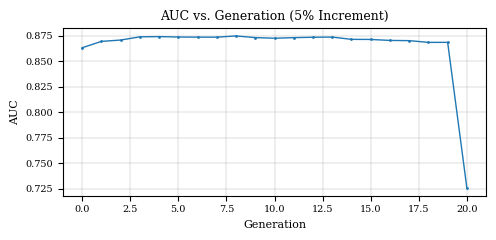

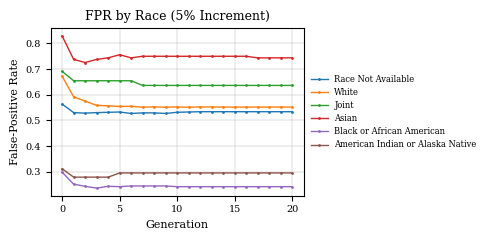

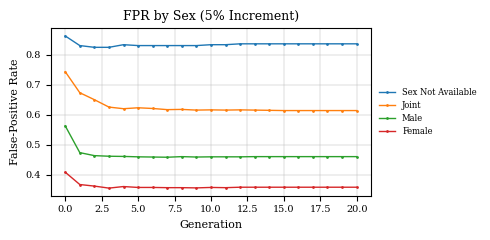

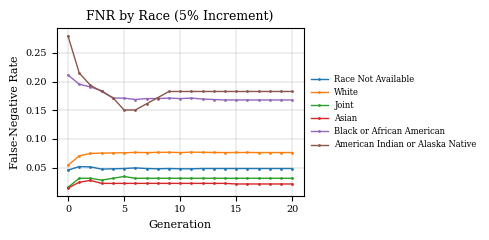

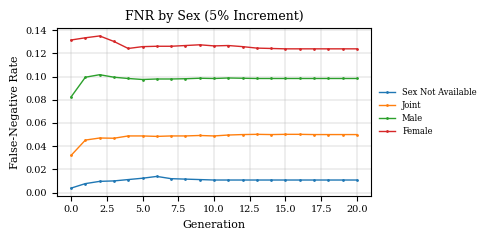

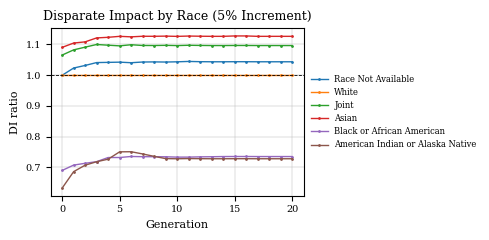

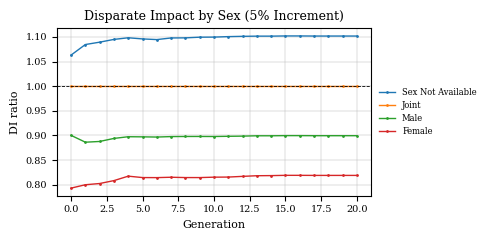

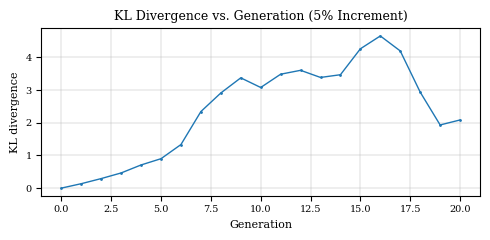

In [18]:
# --------------------------------------------------------
#  Publication-style figures with smaller markers & legends outside
# --------------------------------------------------------
pub_rc = {
    "figure.figsize": (5, 2.5),
    "font.family":    "serif",
    "axes.labelsize": 8,
    "axes.titlesize": 9,
    "xtick.labelsize":7,
    "ytick.labelsize":7,
    "lines.linewidth":1,
    "savefig.dpi":    300,
}

with plt.rc_context(pub_rc):

    # --- AUC (unchanged) ----------------------------------
    fig = plt.figure()
    plt.plot(metrics_df.generation, metrics_df.auc,
             marker="o", markersize=1)
    plt.xlabel("Generation"); plt.ylabel("AUC")
    plt.title("AUC vs. Generation (5% Increment)")
    plt.grid(True, linewidth=.3)
    plt.tight_layout(); plt.savefig("perf_vs_gen.png"); plt.show()

    # --- FPR by race --------------------------------------
    fig = plt.figure()
    for r in race_groups:
        plt.plot(metrics_df.generation,
                 metrics_df[f"FPR_race_{r}"],
                 marker="o", markersize=1,
                 label=r)
    plt.xlabel("Generation"); plt.ylabel("False-Positive Rate")
    plt.title("FPR by Race (5% Increment)")
    plt.grid(True, linewidth=.3)
    plt.legend(loc="center left", bbox_to_anchor=(1,0.5), fontsize=6, frameon=False)
    plt.tight_layout(); plt.savefig("fpr_race.png"); plt.show()

    # --- FPR by sex ---------------------------------------
    fig = plt.figure()
    for s in sex_groups:
        plt.plot(metrics_df.generation,
                 metrics_df[f"FPR_sex_{s}"],
                 marker="o", markersize=1,
                 label=s)
    plt.xlabel("Generation"); plt.ylabel("False-Positive Rate")
    plt.title("FPR by Sex (5% Increment)")
    plt.grid(True, linewidth=.3)
    plt.legend(loc="center left", bbox_to_anchor=(1,0.5), fontsize=6, frameon=False)
    plt.tight_layout(); plt.savefig("fpr_sex.png"); plt.show()

    # --- FNR by race --------------------------------------
    fig = plt.figure()
    for r in race_groups:
        plt.plot(metrics_df.generation,
                 metrics_df[f"FNR_race_{r}"],
                 marker="o", markersize=1,
                 label=r)
    plt.xlabel("Generation"); plt.ylabel("False-Negative Rate")
    plt.title("FNR by Race (5% Increment)")
    plt.grid(True, linewidth=.3)
    plt.legend(loc="center left", bbox_to_anchor=(1,0.5), fontsize=6, frameon=False)
    plt.tight_layout(); plt.savefig("fnr_race.png"); plt.show()

    # --- FNR by sex ------------------------------------------
    fig = plt.figure()
    for s in sex_groups:
        plt.plot(metrics_df.generation,
                 metrics_df[f"FNR_sex_{s}"],
                 marker="o", markersize=1,
                 label=s)
    plt.xlabel("Generation"); plt.ylabel("False-Negative Rate")
    plt.title("FNR by Sex (5% Increment)")
    plt.grid(True, linewidth=.3)
    plt.legend(loc="center left", bbox_to_anchor=(1,0.5), fontsize=6, frameon=False)
    plt.tight_layout(); plt.savefig("fnr_race.png"); plt.show()

    # --- DI by race ---------------------------------------
    fig = plt.figure()
    for r in race_groups:
        plt.plot(metrics_df.generation,
                 metrics_df[f"DI_race_{r}"],
                 marker="o", markersize=1,
                 label=r)
    plt.xlabel("Generation"); plt.ylabel("DI ratio")
    plt.title("Disparate Impact by Race (5% Increment)")
    plt.axhline(1, ls="--", lw=.6, c="k")
    plt.grid(True, linewidth=.3)
    plt.legend(loc="center left", bbox_to_anchor=(1,0.5), fontsize=6, frameon=False)
    plt.tight_layout(); plt.savefig("di_race.png"); plt.show()
 
    # --- DI by sex ----------------------------------------
    fig = plt.figure()
    for s in sex_groups:
        plt.plot(metrics_df.generation,
                 metrics_df[f"DI_sex_{s}"],
                 marker="o", markersize=1,
                 label=s)
    plt.xlabel("Generation"); plt.ylabel("DI ratio")
    plt.title("Disparate Impact by Sex (5% Increment)")
    plt.axhline(1, ls="--", lw=.6, c="k")
    plt.grid(True, linewidth=.3)
    plt.legend(loc="center left", bbox_to_anchor=(1,0.5), fontsize=6, frameon=False)
    plt.tight_layout(); plt.savefig("di_sex.png"); plt.show()

    pub_rc = {
    "figure.figsize": (3.5, 2.5),
    "font.family": "serif",
    "axes.labelsize": 8,
    "axes.titlesize": 9,
    "xtick.labelsize": 7,
    "ytick.labelsize": 7,
    "lines.linewidth": 1,
    "savefig.dpi": 300,
}

    fig = plt.figure()
    plt.plot(metrics_df.generation,
             metrics_df.KL_to_baseline,
             marker="o", markersize=1)
    plt.xlabel("Generation")
    plt.ylabel("KL divergence")
    plt.title("KL Divergence vs. Generation (5% Increment)")
    plt.grid(True, linewidth=.3)
    plt.tight_layout()
    plt.savefig("kl_vs_gen.png")
    plt.show()



## Model Loop with 10% Increment

In [23]:
# ------------------------------------------------ initial copies
X_tr, X_te = X_train_orig.copy(), X_test_orig.copy()
y_tr_true = y_train.copy()

metrics_rows = []

# attributes for group metrics
race_groups = X_te['derived_race'].unique()
sex_groups  = X_te['derived_sex'].unique()
ref_race = X_tr['derived_race'].value_counts().idxmax()
ref_sex  = X_tr['derived_sex'].value_counts().idxmax()

# ------------------------------------------------ Generation 0
proc_tr, proc_te = build_proc(X_tr, X_te, numeric_cols, categorical_cols)
clf = LogisticRegression(solver='lbfgs', max_iter=5000, n_jobs=-1, random_state=42)
clf.fit(proc_tr, y_tr_true)
tr_prob = clf.predict_proba(proc_tr)[:,1]
te_prob = clf.predict_proba(proc_te)[:,1]

X_tr['Approval_Score_1'] = tr_prob
X_te['Approval_Score_1'] = te_prob
numeric_cols.append('Approval_Score_1')
prev_bin = (tr_prob>=0.5).astype(int)       # for blending next gen


metrics_rows.append(
    log_metrics(0, y_test, te_prob, X_te, ref_hist=None, bin_edges=None)
)

# reference histogram for KL
baseline_hist, bin_edges = np.histogram(te_prob, bins=50, range=(0, 1), density=True)



# ------------------- Progressive loop (no feature drop) -------------------
base_w, num_gens = 0.10, 10          # 5 % more synthetic each gen
for g in range(1, num_gens + 1):
    print(f"Gen {g}…  (synthetic weight {min(1, base_w*g):.2f})")

    # 1.  Blend labels ------------------------------------------------------
    synth_w = min(1.0, base_w * g)
    y_blend = y_tr_true.copy()
    repl_idx = np.random.choice(len(y_blend), int(synth_w * len(y_blend)), replace=False)
    y_blend.iloc[repl_idx] = prev_bin[repl_idx]

    # 2.  Re-build processed matrices with *all* original features + scores
    proc_tr, proc_te = build_proc(X_tr, X_te, numeric_cols, categorical_cols)

    # 3.  Retrain logistic regression --------------------------------------
    clf = LogisticRegression(solver="lbfgs", max_iter=2000, n_jobs=-1, random_state=42)
    clf.fit(proc_tr, y_blend)

    # 4.  Predictions and new synthetic score ------------------------------
    tr_prob = clf.predict_proba(proc_tr)[:, 1]
    te_prob = clf.predict_proba(proc_te)[:, 1]
    prev_bin = (tr_prob >= 0.5).astype(int)

    if g < num_gens:                    # add feature for next round
        sc_name = f"Approval_Score_{g+1}"
        X_tr[sc_name] = tr_prob
        X_te[sc_name] = te_prob
        numeric_cols.append(sc_name)    # keep expanding numeric list

    # 5.  Log metrics (unchanged) ------------------------------------------
    metrics_rows.append(
        log_metrics(g, y_test, te_prob, X_te,
                    ref_hist=baseline_hist, bin_edges=bin_edges)
    )


# assemble results
metrics_df = pd.DataFrame(metrics_rows)



Gen 1…  (synthetic weight 0.10)
Gen 2…  (synthetic weight 0.20)
Gen 3…  (synthetic weight 0.30)
Gen 4…  (synthetic weight 0.40)
Gen 5…  (synthetic weight 0.50)
Gen 6…  (synthetic weight 0.60)
Gen 7…  (synthetic weight 0.70)
Gen 8…  (synthetic weight 0.80)
Gen 9…  (synthetic weight 0.90)
Gen 10…  (synthetic weight 1.00)


## Visualizations

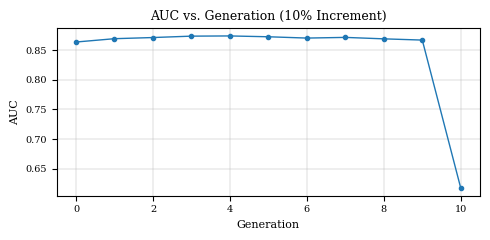

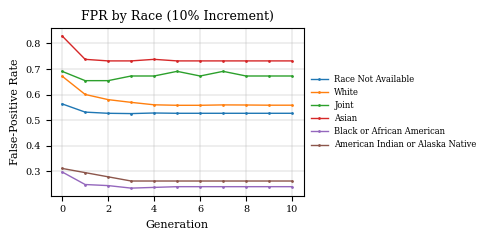

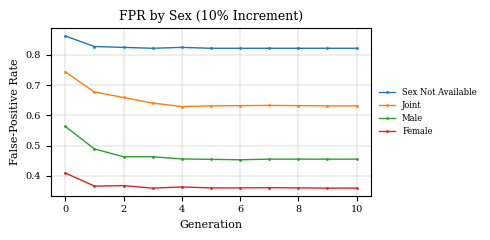

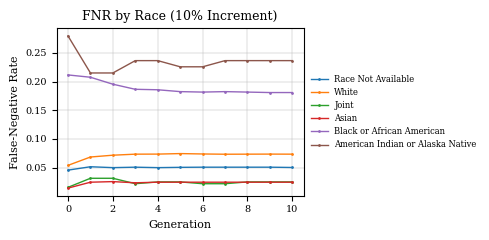

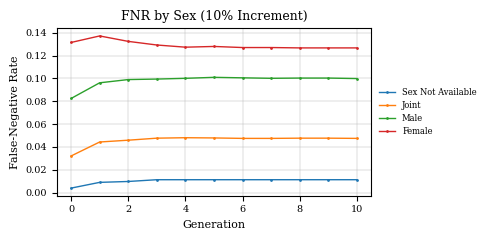

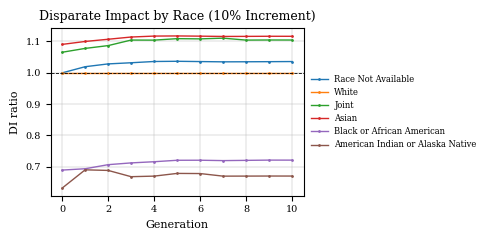

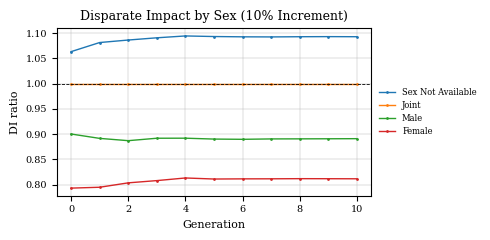

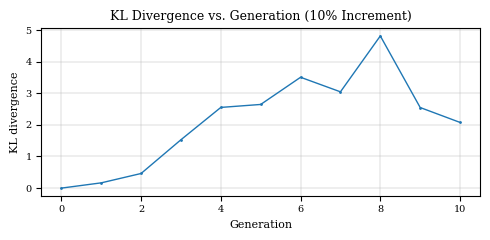

In [24]:
# --------------------------------------------------------
#  Publication-style figures with smaller markers & legends outside
# --------------------------------------------------------
pub_rc = {
    "figure.figsize": (5, 2.5),
    "font.family":    "serif",
    "axes.labelsize": 8,
    "axes.titlesize": 9,
    "xtick.labelsize":7,
    "ytick.labelsize":7,
    "lines.linewidth":1,
    "savefig.dpi":    300,
}

with plt.rc_context(pub_rc):

    # --- AUC (unchanged) ----------------------------------
    fig = plt.figure()
    plt.plot(metrics_df.generation, metrics_df.auc,
             marker="o", markersize=3)
    plt.xlabel("Generation"); plt.ylabel("AUC")
    plt.title("AUC vs. Generation (10% Increment)")
    plt.grid(True, linewidth=.3)
    plt.tight_layout(); plt.savefig("perf_vs_gen.png"); plt.show()

    # --- FPR by race --------------------------------------
    fig = plt.figure()
    for r in race_groups:
        plt.plot(metrics_df.generation,
                 metrics_df[f"FPR_race_{r}"],
                 marker="o", markersize=1,
                 label=r)
    plt.xlabel("Generation"); plt.ylabel("False-Positive Rate")
    plt.title("FPR by Race (10% Increment)")
    plt.grid(True, linewidth=.3)
    plt.legend(loc="center left", bbox_to_anchor=(1,0.5), fontsize=6, frameon=False)
    plt.tight_layout(); plt.savefig("fpr_race.png"); plt.show()

    # --- FPR by sex ---------------------------------------
    fig = plt.figure()
    for s in sex_groups:
        plt.plot(metrics_df.generation,
                 metrics_df[f"FPR_sex_{s}"],
                 marker="o", markersize=1,
                 label=s)
    plt.xlabel("Generation"); plt.ylabel("False-Positive Rate")
    plt.title("FPR by Sex (10% Increment)")
    plt.grid(True, linewidth=.3)
    plt.legend(loc="center left", bbox_to_anchor=(1,0.5), fontsize=6, frameon=False)
    plt.tight_layout(); plt.savefig("fpr_sex.png"); plt.show()

    # --- FNR by race --------------------------------------
    fig = plt.figure()
    for r in race_groups:
        plt.plot(metrics_df.generation,
                 metrics_df[f"FNR_race_{r}"],
                 marker="o", markersize=1,
                 label=r)
    plt.xlabel("Generation"); plt.ylabel("False-Negative Rate")
    plt.title("FNR by Race (10% Increment)")
    plt.grid(True, linewidth=.3)
    plt.legend(loc="center left", bbox_to_anchor=(1,0.5), fontsize=6, frameon=False)
    plt.tight_layout(); plt.savefig("fnr_race.png"); plt.show()

    # --- FNR by sex ------------------------------------------
    fig = plt.figure()
    for s in sex_groups:
        plt.plot(metrics_df.generation,
                 metrics_df[f"FNR_sex_{s}"],
                 marker="o", markersize=1,
                 label=s)
    plt.xlabel("Generation"); plt.ylabel("False-Negative Rate")
    plt.title("FNR by Sex (10% Increment)")
    plt.grid(True, linewidth=.3)
    plt.legend(loc="center left", bbox_to_anchor=(1,0.5), fontsize=6, frameon=False)
    plt.tight_layout(); plt.savefig("fnr_race.png"); plt.show()

    # --- DI by race ---------------------------------------
    fig = plt.figure()
    for r in race_groups:
        plt.plot(metrics_df.generation,
                 metrics_df[f"DI_race_{r}"],
                 marker="o", markersize=1,
                 label=r)
    plt.xlabel("Generation"); plt.ylabel("DI ratio")
    plt.title("Disparate Impact by Race (10% Increment)")
    plt.axhline(1, ls="--", lw=.6, c="k")
    plt.grid(True, linewidth=.3)
    plt.legend(loc="center left", bbox_to_anchor=(1,0.5), fontsize=6, frameon=False)
    plt.tight_layout(); plt.savefig("di_race.png"); plt.show()
 
    # --- DI by sex ----------------------------------------
    fig = plt.figure()
    for s in sex_groups:
        plt.plot(metrics_df.generation,
                 metrics_df[f"DI_sex_{s}"],
                 marker="o", markersize=1,
                 label=s)
    plt.xlabel("Generation"); plt.ylabel("DI ratio")
    plt.title("Disparate Impact by Sex (10% Increment)")
    plt.axhline(1, ls="--", lw=.6, c="k")
    plt.grid(True, linewidth=.3)
    plt.legend(loc="center left", bbox_to_anchor=(1,0.5), fontsize=6, frameon=False)
    plt.tight_layout(); plt.savefig("di_sex.png"); plt.show()

    pub_rc = {
    "figure.figsize": (3.5, 2.5),
    "font.family": "serif",
    "axes.labelsize": 8,
    "axes.titlesize": 9,
    "xtick.labelsize": 7,
    "ytick.labelsize": 7,
    "lines.linewidth": 1,
    "savefig.dpi": 300,
}

    fig = plt.figure()
    plt.plot(metrics_df.generation,
             metrics_df.KL_to_baseline,
             marker="o", markersize=1)
    plt.xlabel("Generation")
    plt.ylabel("KL divergence")
    plt.title("KL Divergence vs. Generation (10% Increment)")
    plt.grid(True, linewidth=.3)
    plt.tight_layout()
    plt.savefig("kl_vs_gen.png")
    plt.show()

